### Ejercicio(s) práctico(s)

In [54]:
%%time
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings("ignore")

CPU times: total: 0 ns
Wall time: 0 ns


In [2]:
%pwd

'e:\\SANTIAGO\\Documents\\SANTIAGO\\UNIVERSIDAD\\MAESTRÍA INTELIGENCIA ARTIFICIAL\\TESIS'

In [55]:
#header = pd.read_csv("gaussmx_bg_n_20240907_1705.csv")
header = pd.read_csv("kmeans_bg_n_20240907_1313.csv")

In [56]:
header = header[((header['L'] != 0) & (header['a'] != 0) & (header['b'] != 0)) & (header['class'] != 3)].drop_duplicates(subset=['image','height','width','class', 'L','a','b']).reset_index(drop=True)

In [57]:
# Concatenate class 0, class 1, and the sampled class 2
balanced_data = pd.concat([header[header['class'] == 0].sample(n=1700000, random_state=42), header[header['class'] == 1] , header[header['class'] == 2].sample(n=1700000, random_state=42)])

# Optional: Shuffle the concatenated DataFrame
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [58]:
balanced_data['class'].value_counts()

class
2    1700000
0    1700000
1    1627935
Name: count, dtype: int64

In [59]:
import dask.dataframe as dd

#data_gmx = dd.from_pandas(header[(header['image'] <= 2000)], npartitions=8)
data_gmx = dd.from_pandas(balanced_data, npartitions=8)
#data_gmx= dd.read_csv("gaussmx_bg_n_20240907_1705.csv")

In [60]:
len(data_gmx)

5027935

In [61]:
X = data_gmx[['L', 'a', 'b']].to_dask_array(lengths=True)  # Feature columns as np.array
y = data_gmx['class'].to_dask_array(lengths=True) # Label column as np.array

- 2.1 Escale todas las `784` variables con el método `min-max`; pero usando en máximo y el mínimo globales, en lugar de los de cada columna. Vrase el `ejercicio 0312` del capítulo 5, unidad 8 (`ensemble algorithms`).

In [62]:
X_min = X.min()
X_max = X.max()
X_range = X_max - X_min
X_scaled = (X - X_min)/X_range

- 2.2 Divida los datos en un conjunto de entrenamiento y un conjunto de prueba (utilizar $60.000$ registros para el entrenamiento y $10.000$ para prueba). Luego, entrene los siguientes clasificadores optimizando los `hiperparámetros` más representativos (excepto los de regularización) mediante la `validación cruzada `:

  - clasificador SVM.
  - Regresión logística
  - Naive Bayes
  - K-vecinos
  - Árbol de decisión

  Compare los rendimientos de cada uno de ellos.

Respuesta: Dividiendo los datos en entrenamiento y test

In [63]:
from sklearn import metrics
from dask.distributed import Client
import joblib
from sklearn.model_selection import GridSearchCV#, train_test_split
from dask_ml.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=1234)

In [64]:
print(len(X_train)," - ",len(Y_train))
print(len(X_test)," - ",len(Y_test))

4022343  -  4022343
1005592  -  1005592


### Creando modelo 1: Regresión logística

In [13]:
%%time
from sklearn.linear_model import LogisticRegression     #se importa cada clasificador individual

penalty = [None,'l1', 'l2']
max_iter = [100]
#No se usa aquí parámetro de regularización C
parameters_lr = {'penalty': penalty, 'max_iter': max_iter}


gridCV_lr = GridSearchCV( LogisticRegression(random_state = 12345), parameters_lr, n_jobs = -1)
gridCV_lr.fit(X_train, Y_train)
#-----------
best_penalty = gridCV_lr.best_params_['penalty']
best_max_iter  = gridCV_lr.best_params_['max_iter']


print("El mejor penalty es: " + str(best_penalty))
print("El mejor número de máximas iteraciones es: " + str(best_max_iter))

El mejor penalty es: l2
El mejor número de máximas iteraciones es: 100
CPU times: total: 35.4 s
Wall time: 60 s


In [65]:
#LR_best = LogisticRegression(penalty=best_penalty, max_iter=best_max_iter, random_state = 12345)
#LR_best.fit(X_train, Y_train)
LR_best = gridCV_lr.best_estimator_


LRPickle = open('LR_pickle_file', 'wb') 
pickle.dump(LR_best, LRPickle)  
# close the file
LRPickle.close()

In [89]:
loaded_model_lr = pickle.load(open('LR_pickle_file', 'rb'))
Y_pred_lr = loaded_model_lr.predict(X_test)
print( "El mejor accuracy del LR : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_lr),3)))

El mejor accuracy del LR : 0.596


In [90]:
print(metrics.classification_report(Y_test, Y_pred_lr))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68    340195
           1       0.46      0.33      0.39    325482
           2       0.64      0.71      0.68    339915

    accuracy                           0.60   1005592
   macro avg       0.58      0.59      0.58   1005592
weighted avg       0.58      0.60      0.58   1005592



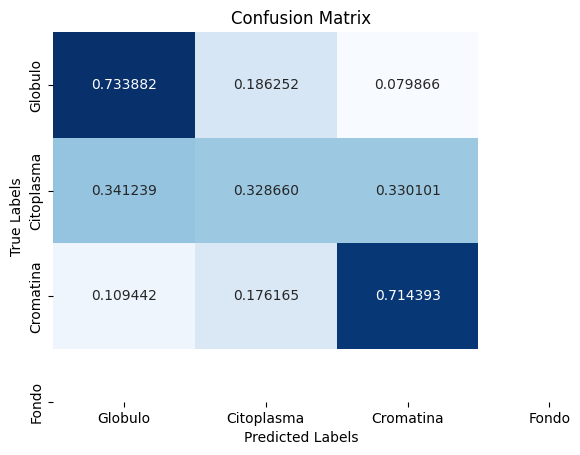

In [19]:
cm = confusion_matrix(Y_test, Y_pred_lr, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 2: Naive bayes

In [20]:
%%time
from sklearn.naive_bayes  import GaussianNB
var_smoothing= [1e-3, 1e-11, 1e-9, 1e-7, 1e-5, 1e-1, 1, 10 ]#
parameters_nb = {'var_smoothing': var_smoothing}


gridCV_nb = GridSearchCV(GaussianNB(), parameters_nb, n_jobs = -1)
gridCV_nb.fit(X_train, Y_train)
#-----------
best_var_smoothing = gridCV_nb.best_params_['var_smoothing']

print("El mejor var_smoothing es: " + str(best_var_smoothing))

El mejor var_smoothing es: 1e-05
CPU times: total: 3.72 s
Wall time: 41.2 s


In [25]:
#NB_best = GaussianNB(var_smoothing=best_var_smoothing)
#NB_best.fit(X_train, Y_train)
NB_best = gridCV_nb.best_estimator_

NBPickle = open('NB_pickle_file', 'wb') 
pickle.dump(NB_best, NBPickle)  
# close the file
NBPickle.close()

In [26]:
loaded_model_nb = pickle.load(open('NB_pickle_file', 'rb'))
Y_pred_nb = loaded_model_nb.predict(X_test)
print( "El mejor accuracy del NB : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_nb),3)))

El mejor accuracy del NB : 0.577


In [91]:
print(metrics.classification_report(Y_test, Y_pred_nb))

              precision    recall  f1-score   support

           0       0.55      0.88      0.68    340195
           1       0.45      0.15      0.22    325482
           2       0.65      0.69      0.67    339915

    accuracy                           0.58   1005592
   macro avg       0.55      0.57      0.52   1005592
weighted avg       0.55      0.58      0.53   1005592



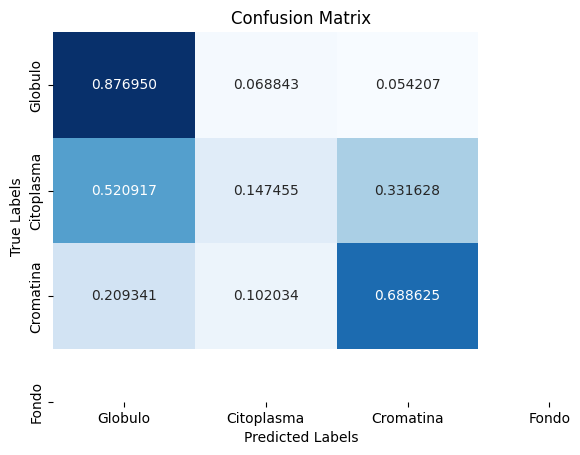

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_nb, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 3: k-vecinos

In [28]:
%%time
from sklearn.neighbors    import KNeighborsClassifier   #se importa cada clasificador individual
n_neighbors = [3, 5, 7,]# Mejor número impar [3, 5, 7, 9]
p = [1, 2, 3]
weights = ['uniform','distance']#
parameters_knn = {'n_neighbors': n_neighbors, 'p': p, 'weights': weights}


gridCV_knn = GridSearchCV(KNeighborsClassifier(), parameters_knn, n_jobs = -1)
gridCV_knn.fit(X_train, Y_train)
#-----------


best_n_neighbors = gridCV_knn.best_params_['n_neighbors']
best_p = gridCV_knn.best_params_['p']
best_weights  = gridCV_knn.best_params_['weights']


print("El mejor n_neighbors es: " + str(best_n_neighbors))
print("El mejor p es: " + str(best_p))
print("El mejor weights es: " + str(best_weights))

El mejor n_neighbors es: 7
El mejor p es: 1
El mejor weights es: uniform
CPU times: total: 13.2 s
Wall time: 7min 27s


In [29]:
#KNN_best = KNeighborsClassifier(n_neighbors=best_n_neighbors, p=best_p, weights=best_weights)
#KNN_best.fit(X_train, Y_train)

KNN_best = gridCV_knn.best_estimator_

knnPickle = open('knnpickle_file', 'wb') 
pickle.dump(KNN_best, knnPickle)  

# close the file
knnPickle.close()

In [30]:
loaded_model_knn = pickle.load(open('knnpickle_file', 'rb'))

Y_pred_knn = loaded_model_knn.predict(X_test)
print( "El mejor accuracy del KNN : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_knn),3)))

El mejor accuracy del KNN : 0.568


In [92]:
print(metrics.classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

           0       0.60      0.72      0.66    340195
           1       0.43      0.34      0.38    325482
           2       0.63      0.64      0.63    339915

    accuracy                           0.57   1005592
   macro avg       0.55      0.56      0.56   1005592
weighted avg       0.56      0.57      0.56   1005592



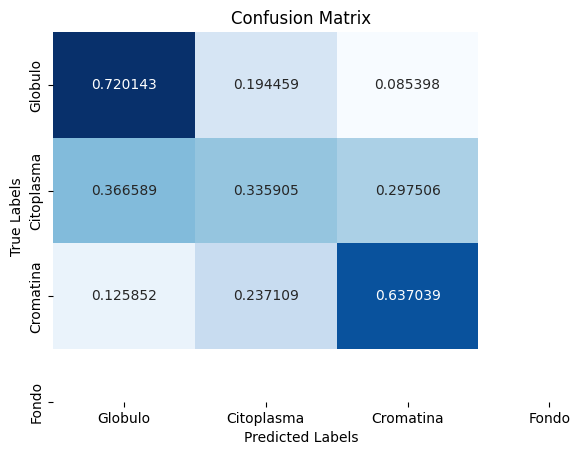

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_knn, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 4: Decision Tree

In [32]:
%%time
from sklearn.tree import  DecisionTreeClassifier
depth_grid = np.arange(1,22,5)
min_samples_leaf_grid = np.arange(2,23,5) #
max_leaf_nodes_grid = np.arange(23,54,5)#
parameters_dt = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid}


gridCV_dt = GridSearchCV(DecisionTreeClassifier(random_state = 12345), parameters_dt, n_jobs = -1)
gridCV_dt.fit(X_train, Y_train)
#-----------
best_depth = gridCV_dt.best_params_['max_depth']
best_min_samples_leaf = gridCV_dt.best_params_['min_samples_leaf']
best_max_leaf_nodes = gridCV_dt.best_params_['max_leaf_nodes']


print("La mejor max_depth del árbol: " + str(best_depth))
print("El mejor min_samples_leaf del árbol: " + str(best_min_samples_leaf))
print("El mejor max_leaf_nodes del árbol: " + str(best_max_leaf_nodes))

La mejor max_depth del árbol: 11
El mejor min_samples_leaf del árbol: 2
El mejor max_leaf_nodes del árbol: 53
CPU times: total: 22.4 s
Wall time: 24min 26s


In [33]:
#DT_best = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345)
#DT_best.fit(X_train, Y_train)

DT_best = gridCV_dt.best_estimator_

DTPickle = open('dt_pickle_file', 'wb') 
pickle.dump(DT_best, DTPickle)  

# close the file
DTPickle.close()

In [34]:
loaded_model_dt = pickle.load(open('dt_pickle_file', 'rb'))

Y_pred_dt = loaded_model_dt.predict(X_test)
print( "La mejor accuracy del árbol : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_dt),3)))

La mejor accuracy del árbol : 0.606


In [93]:
print(metrics.classification_report(Y_test, Y_pred_dt))

              precision    recall  f1-score   support

           0       0.62      0.82      0.70    340195
           1       0.49      0.24      0.33    325482
           2       0.64      0.74      0.69    339915

    accuracy                           0.61   1005592
   macro avg       0.58      0.60      0.57   1005592
weighted avg       0.58      0.61      0.58   1005592



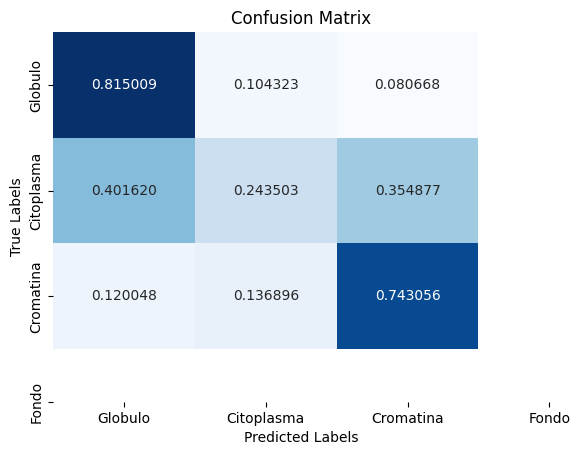

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_dt, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 5: SVM

In [104]:
%%time
from sklearn.svm  import SVC

degree = [2]#,3
kernel =  ['poly']#,'rbf'

#No se usa aquí parámetro de regularización C
parameters_svm = {'degree': degree, 'kernel': kernel}


#gridCV_svm = GridSearchCV(SVC(random_state = 12345), parameters_svm, n_jobs = -1)
#gridCV_svm.fit(X_train, Y_train)
#-----------
#best_degree = gridCV_svm.best_params_['degree']
#best_kernel = gridCV_svm.best_params_['kernel']


#print("El mejor degree es: " + str(best_degree))
#print("El mejor kernel es: " + str(best_kernel))

CPU times: total: 0 ns
Wall time: 0 ns


In [105]:
#SVM_best = SVC(degree=best_degree, kernel=best_kernel, gamma='scale', probability= True,  random_state = 12345)# gamma = 'auto', 
#SVM_best.fit(X_train, Y_train)

#SVM_best = gridCV_svm.best_estimator_


#Y_pred_svm = SVM_best.predict(X_test)
#print( "El mejor accuracy del SVM : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_svm),3)))

### Creando modelo 6: Voto mayoritario duro

In [80]:
%%time
from sklearn.ensemble import VotingClassifier             # Se importa clasificador por votación

myVotingEnsemble_hard=VotingClassifier(estimators=[('LR',LR_best), ('nb',NB_best), ('knn',KNN_best),  ('dt',DT_best)], voting='hard', verbose = True, n_jobs = -1)#('SVM',SVM_best), 
myVotingEnsemble_hard.fit(X_train, Y_train)

VotingEnsemble_hardPickle = open('VotingEnsemble_hard_pickle_file', 'wb') 
pickle.dump(myVotingEnsemble_hard, VotingEnsemble_hardPickle)  

# close the file
VotingEnsemble_hardPickle.close()

CPU times: total: 1.92 s
Wall time: 24.9 s


In [81]:
loaded_model_VotingEnsemble_hard = pickle.load(open('VotingEnsemble_hard_pickle_file', 'rb'))

Y_pred_VotingEnsemble_hard = loaded_model_VotingEnsemble_hard.predict(X_test)
print( "La mejor accuracy del VotingEnsemble_hard: " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_VotingEnsemble_hard),3)))

La mejor accuracy del VotingEnsemble_hard: 0.603


In [95]:
print(metrics.classification_report(Y_test, Y_pred_VotingEnsemble_hard))

              precision    recall  f1-score   support

           0       0.60      0.84      0.70    340195
           1       0.50      0.23      0.32    325482
           2       0.65      0.72      0.68    339915

    accuracy                           0.60   1005592
   macro avg       0.58      0.60      0.57   1005592
weighted avg       0.58      0.60      0.57   1005592



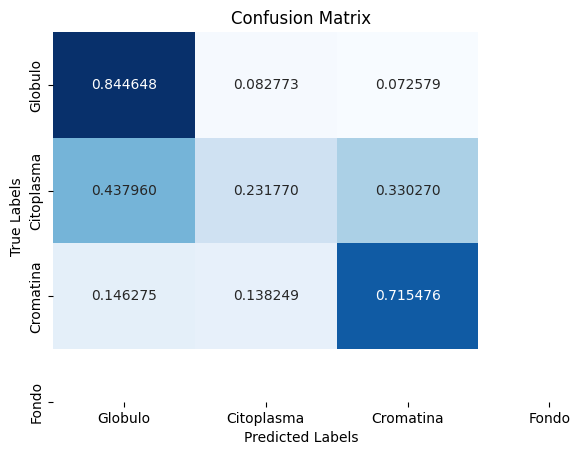

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_VotingEnsemble_hard, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 7: Voto mayoritario suave

In [84]:
%%time
from sklearn.ensemble import VotingClassifier             # Se importa clasificador por votación

myVotingEnsemble_soft=VotingClassifier(estimators=[('LR',LR_best), ('nb',NB_best), ('knn',KNN_best),  ('dt',DT_best)],voting='soft', verbose = True, n_jobs = -1)#('SVM',SVM_best), 
myVotingEnsemble_soft.fit(X_train, Y_train)

VotingEnsemble_softPickle = open('VotingEnsemble_soft_pickle_file', 'wb') 
pickle.dump(myVotingEnsemble_soft, VotingEnsemble_softPickle)  

# close the file
VotingEnsemble_softPickle.close()

CPU times: total: 1.91 s
Wall time: 23.3 s


In [85]:
loaded_model_VotingEnsemble_soft = pickle.load(open('VotingEnsemble_soft_pickle_file', 'rb'))

Y_pred_VotingEnsemble_soft = loaded_model_VotingEnsemble_soft.predict(X_test)
print( "La mejor accuracy del VotingEnsemble_soft: " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_VotingEnsemble_soft),3)))

La mejor accuracy del VotingEnsemble_soft: 0.604


In [97]:
print(metrics.classification_report(Y_test, Y_pred_VotingEnsemble_soft))

              precision    recall  f1-score   support

           0       0.61      0.83      0.70    340195
           1       0.50      0.25      0.33    325482
           2       0.64      0.72      0.68    339915

    accuracy                           0.60   1005592
   macro avg       0.58      0.60      0.57   1005592
weighted avg       0.58      0.60      0.57   1005592



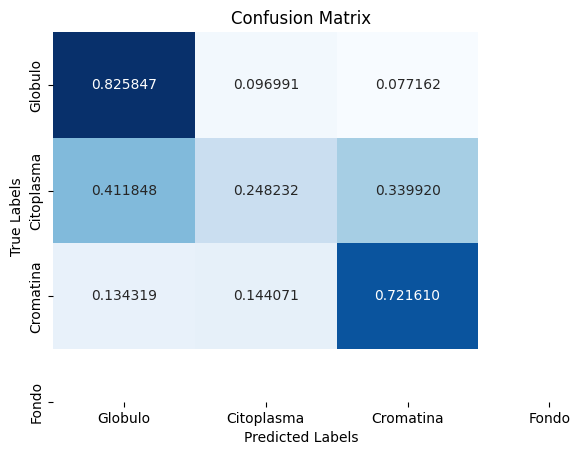

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_VotingEnsemble_soft, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 8: Bagging classifier

In [41]:
%%time
from sklearn.ensemble import BaggingClassifier

n_estimators_bag= [5, 10]#
parameters_bagging = {'n_estimators': n_estimators_bag}

gridCV_bagging= GridSearchCV(BaggingClassifier(KNN_best), parameters_bagging, n_jobs = -1)
gridCV_bagging.fit(X_train, Y_train)
#-----------
best_n_estimators_bag = gridCV_bagging.best_params_['n_estimators']


print("El mejor n_estimators es: " + str(best_n_estimators_bag))

El mejor n_estimators es: 10
CPU times: total: 1min 39s
Wall time: 7min 46s


In [42]:
#bagging_best = BaggingClassifier(KNN_best, n_estimators=best_n_estimators_bag,  n_jobs=-1)
#bagging_best.fit(X_train, Y_train)
bagging_best = gridCV_bagging.best_estimator_

baggingPickle = open('bagging_pickle_file', 'wb') 
pickle.dump(bagging_best, baggingPickle)  

# close the file
baggingPickle.close()

In [43]:
loaded_model_bagging = pickle.load(open('bagging_pickle_file', 'rb'))

Y_pred_bagging = loaded_model_bagging.predict(X_test)
print( "El mejor accuracy del bagging : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_bagging ),3)))

El mejor accuracy del bagging : 0.569


In [98]:
print(metrics.classification_report(Y_test, Y_pred_bagging))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65    340195
           1       0.43      0.33      0.37    325482
           2       0.62      0.66      0.64    339915

    accuracy                           0.57   1005592
   macro avg       0.55      0.57      0.56   1005592
weighted avg       0.56      0.57      0.56   1005592



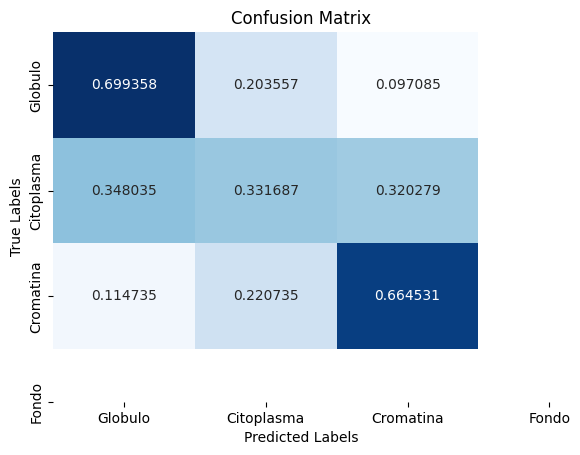

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_bagging, normalize='true')

sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 9: Random forest classifier

In [46]:
%%time
from sklearn.ensemble import RandomForestClassifier

n_estimators_rfc= [100]#[10, 50, 100, 500
parameters_rfc = {'n_estimators': n_estimators_rfc}

gridCV_rfc= GridSearchCV(RandomForestClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345, class_weight = "balanced"), parameters_rfc, n_jobs = -1)
gridCV_rfc.fit(X_train, Y_train)
#-----------
best_n_estimators_rfc = gridCV_rfc.best_params_['n_estimators']


print("El mejor n_estimators es: " + str(best_n_estimators_rfc))

El mejor n_estimators es: 100
CPU times: total: 6min 1s
Wall time: 12min 33s


In [48]:
# Clasificación por Random Forest.
#RFC_best = RandomForestClassifier(n_estimators=best_n_estimators_rfc , max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345, class_weight = "balanced")
#RFC_best.fit(X_train, Y_train)

RFC_best = gridCV_rfc.best_estimator_

RFCPickle = open('RFC_pickle_file', 'wb') 
pickle.dump(RFC_best, RFCPickle)  

# close the file
RFCPickle.close()

CPU times: total: 0 ns
Wall time: 29 ms


In [49]:
%%time
loaded_model_RFC = pickle.load(open('RFC_pickle_file', 'rb'))

Y_pred_rfc = loaded_model_RFC.predict(X_test)
print( "Random Forest accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_rfc),3)))

Random Forest accuracy : 0.602


In [99]:
print(metrics.classification_report(Y_test, Y_pred_rfc))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70    340195
           1       0.53      0.17      0.25    325482
           2       0.61      0.80      0.69    339915

    accuracy                           0.60   1005592
   macro avg       0.58      0.60      0.55   1005592
weighted avg       0.58      0.60      0.55   1005592



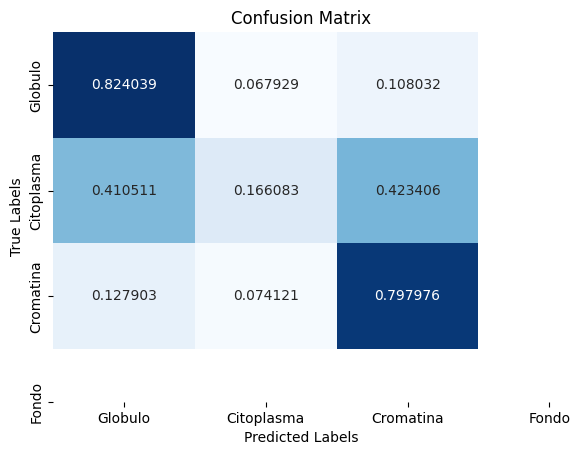

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_rfc, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 10: AdaBoost classifier

In [66]:
%%time
from sklearn.ensemble import AdaBoostClassifier

n_estimators_ab= [10, 20]#, 20, 50, 100
learning_rate_ab= [1e-1, 1]#

parameters_adaboost = {'n_estimators': n_estimators_ab, 'learning_rate':learning_rate_ab}

gridCV_ab = GridSearchCV(AdaBoostClassifier(LR_best,random_state=123), parameters_adaboost , n_jobs = -1)
gridCV_ab.fit(X_train, Y_train)
#-----------
best_n_estimators_ab = gridCV_ab.best_params_['n_estimators']
best_learning_rate_ab = gridCV_ab.best_params_['learning_rate']


print("El mejor n_estimators es: " + str(best_n_estimators_ab))
print("El mejor learning_rate es: " + str(best_learning_rate_ab))

El mejor n_estimators es: 20
El mejor learning_rate es: 1
CPU times: total: 2min 4s
Wall time: 5min 10s


In [67]:
# Clasificación por adaboost.
#AdaBoost_best = AdaBoostClassifier(LR_best, random_state=123, n_estimators=best_n_estimators_ab, learning_rate=best_learning_rate_ab)
#AdaBoost_best.fit(X_train, Y_train)
AdaBoost_best = gridCV_ab.best_estimator_

AdaBoostPickle = open('AdaBoost_pickle_file', 'wb') 
pickle.dump(AdaBoost_best, AdaBoostPickle)  

# close the file
AdaBoostPickle.close()

In [68]:
%%time
loaded_model_AdaBoost = pickle.load(open('RFC_pickle_file', 'rb'))

Y_pred_ada = loaded_model_AdaBoost.predict(X_test)
print( "Adaboost accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_ada),3)))

Adaboost accuracy : 0.602
CPU times: total: 5.27 s
Wall time: 4.74 s


In [100]:
print(metrics.classification_report(Y_test, Y_pred_ada))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70    340195
           1       0.53      0.17      0.25    325482
           2       0.61      0.80      0.69    339915

    accuracy                           0.60   1005592
   macro avg       0.58      0.60      0.55   1005592
weighted avg       0.58      0.60      0.55   1005592



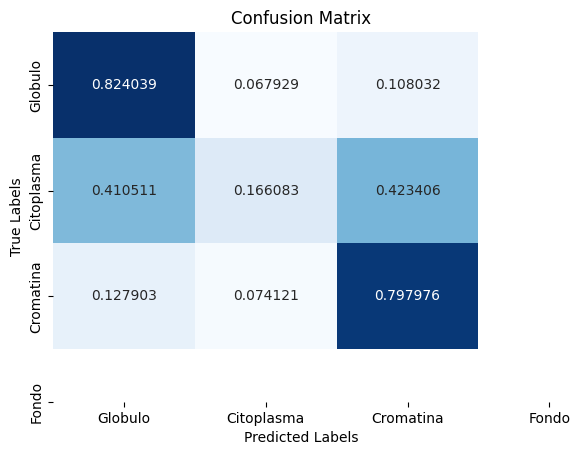

In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_ada, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 11: GradientBoost classifier

In [69]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

n_estimators_gbc= [10]#, 50, 100
learning_rate_gbc= [1]#, 1e-1
parameters_gbc = {'n_estimators': n_estimators_gbc, 'learning_rate':learning_rate_gbc}

gridCV_gbc= GridSearchCV(GradientBoostingClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345), parameters_gbc, n_jobs = -1)

gridCV_gbc.fit(X_train, Y_train)
#-----------
best_n_estimators_gbc = gridCV_gbc.best_params_['n_estimators']
best_learning_rate_gbc = gridCV_gbc.best_params_['learning_rate']


print("El mejor n_estimators es: " + str(best_n_estimators_gbc))
print("El mejor learning rate es: " + str(best_learning_rate_gbc))

El mejor n_estimators es: 10
El mejor learning rate es: 1
CPU times: total: 4min 21s
Wall time: 9min 36s


In [70]:
# Clasificación por Gradient Boosting.
#GBC_best = GradientBoostingClassifier(n_estimators=best_n_estimators_gbc, learning_rate=best_learning_rate_gbc, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345)
#GBC_best.fit(X_train, Y_train)

GBC_best = gridCV_gbc.best_estimator_

GBC_Pickle = open('GBC_pickle_file', 'wb') 
pickle.dump(GBC_best, GBC_Pickle)  

# close the file
GBC_Pickle.close()

In [71]:
%%time
loaded_model_GBC = pickle.load(open('GBC_pickle_file', 'rb'))

Y_pred_gbc = GBC_best.predict(X_test)
print( "Gradient Boosting accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred_gbc),3)))

Gradient Boosting accuracy : 0.608
CPU times: total: 1.56 s
Wall time: 1.14 s


In [101]:
print(metrics.classification_report(Y_test, Y_pred_gbc))

              precision    recall  f1-score   support

           0       0.63      0.79      0.70    340195
           1       0.50      0.28      0.36    325482
           2       0.64      0.74      0.69    339915

    accuracy                           0.61   1005592
   macro avg       0.59      0.60      0.58   1005592
weighted avg       0.59      0.61      0.58   1005592



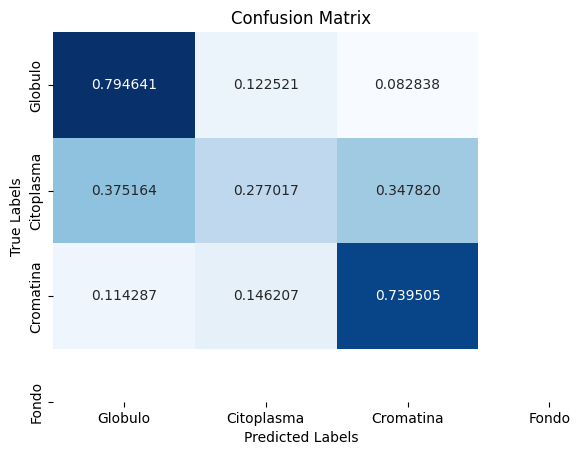

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_gbc, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Creando modelo 12: XGradientBoost classifier

In [74]:
%%time
from xgboost import XGBClassifier

n_estimators_XGBC= [50, 20]#10, 
learning_rate_XGBC= [1, 1e-1]#
parameters_XGBC = {'n_estimators': n_estimators_XGBC, 'learning_rate':learning_rate_XGBC}

Y_train_int = Y_train.astype(int)

gridCV_XGBC= GridSearchCV(XGBClassifier(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345), parameters_XGBC, n_jobs = -1)
gridCV_XGBC.fit(X_train, Y_train_int)
#-----------
best_n_estimators_XGBC = gridCV_XGBC.best_params_['n_estimators']
best_learning_rate_XGBC = gridCV_XGBC.best_params_['learning_rate']


print("El mejor n_estimators es: " + str(best_n_estimators_XGBC))
print("El mejor learning rate es: " + str(best_learning_rate_XGBC))

El mejor n_estimators es: 50
El mejor learning rate es: 0.1
CPU times: total: 7min 39s
Wall time: 6min 32s


In [75]:
# Clasificación por XGB.
#XGBC_best = XGBClassifier(n_estimators=best_n_estimators_XGBC, learning_rate=best_learning_rate_XGBC, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, max_leaf_nodes=best_max_leaf_nodes, random_state = 12345)
#XGBC_best.fit(X_train, Y_train_int)

XGBC_best = gridCV_XGBC.best_estimator_

XGBC_Pickle = open('XGBC_pickle_file', 'wb') 
pickle.dump(XGBC_best, XGBC_Pickle)  

# close the file
XGBC_Pickle.close()

In [76]:
%%time
loaded_model_XGBC = pickle.load(open('XGBC_pickle_file', 'rb'))

Y_pred_XGBC = XGBC_best.predict(X_test)
print( "XGBoost accuracy : " + str(np.round(metrics.accuracy_score(Y_test.astype(int),Y_pred_XGBC),3)))

XGBoost accuracy : 0.609
CPU times: total: 15.1 s
Wall time: 1.4 s


In [102]:
print(metrics.classification_report(Y_test, Y_pred_XGBC))

              precision    recall  f1-score   support

           0       0.63      0.80      0.70    340195
           1       0.50      0.27      0.35    325482
           2       0.64      0.74      0.69    339915

    accuracy                           0.61   1005592
   macro avg       0.59      0.60      0.58   1005592
weighted avg       0.59      0.61      0.58   1005592



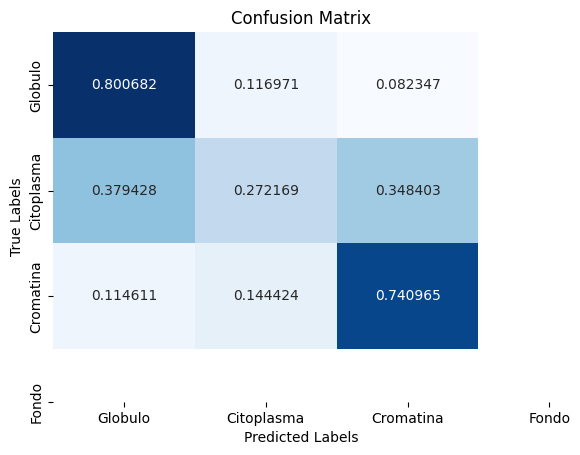

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_XGBC, normalize='true')


sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', cbar=False,
            xticklabels=['Globulo','Citoplasma','Cromatina','Fondo'],
            yticklabels=['Globulo','Citoplasma','Cromatina','Fondo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()